In [1]:
import mne
raw = mne.io.read_raw_edf('yasa_example_night_young.edf', preload=True)
raw

Extracting EDF parameters from G:\다른 컴퓨터\lenovo (1)\USC\code_mine\yasa_examination\yasa_example_night_young.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5783999  =      0.000 ... 28919.995 secs...


<RawEDF | yasa_example_night_young.edf, 23 x 5784000 (28920.0 s), ~1015.0 MB, data loaded>

In [2]:
print(raw.ch_names)

['ROC-A1', 'LOC-A2', 'C3-A2', 'O2-A1', 'C4-A1', 'O1-A2', 'EMG1-EMG2', 'Fp1-A2', 'Fp2-A1', 'F7-A2', 'F3-A2', 'FZ-A2', 'F4-A1', 'F8-A1', 'T3-A2', 'CZ-A2', 'T4-A1', 'T5-A2', 'P3-A2', 'PZ-A2', 'P4-A1', 'T6-A1', 'EKG-R-EKG-L']


In [3]:
# remove the EOG, EMG, and EKG channels
raw.drop_channels(['ROC-A1', 'LOC-A2', 'EMG1-EMG2', 'EKG-R-EKG-L'])
chan = raw.ch_names
print(chan)

['C3-A2', 'O2-A1', 'C4-A1', 'O1-A2', 'Fp1-A2', 'Fp2-A1', 'F7-A2', 'F3-A2', 'FZ-A2', 'F4-A1', 'F8-A1', 'T3-A2', 'CZ-A2', 'T4-A1', 'T5-A2', 'P3-A2', 'PZ-A2', 'P4-A1', 'T6-A1']


In [4]:
# Downsampling and filtering
print(raw.info['sfreq'])

200.0


In [5]:
raw.resample(100)
sf = raw.info['sfreq']
sf

100.0

In [6]:
# 0.3-45 Hz bandpass-filter
raw.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)



<RawEDF | yasa_example_night_young.edf, 19 x 2892000 (28920.0 s), ~419.2 MB, data loaded>

In [7]:
data = raw.get_data() * 1e6
print(data.shape)

(19, 2892000)


In [8]:
# Hynogram
import pandas as pd
hypno = pd.read_csv("yasa_example_night_young_hypno.csv", squeeze=True)
hypno

0      0
1      0
2      0
3      0
4      0
      ..
959    2
960    2
961    2
962    2
963    0
Name: Stage, Length: 964, dtype: int64

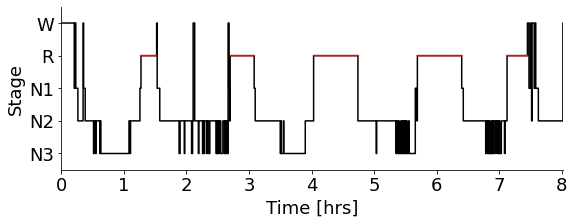

In [9]:
import yasa
yasa.plot_hypnogram(hypno);

In [10]:
# sleep statistics and stage-transition matrix
yasa.sleep_statistics(hypno, sf_hyp=1/30)

{'TIB': 482.0,
 'SPT': 468.5,
 'WASO': 9.0,
 'TST': 459.5,
 'N1': 17.5,
 'N2': 214.0,
 'N3': 85.5,
 'REM': 142.5,
 'NREM': 317.0,
 'SOL': 13.0,
 'Lat_N1': 13.0,
 'Lat_N2': 16.5,
 'Lat_N3': 31.5,
 'Lat_REM': 77.0,
 '%N1': 3.808487486398259,
 '%N2': 46.572361262241564,
 '%N3': 18.607181719260065,
 '%REM': 31.01196953210011,
 '%NREM': 68.98803046789989,
 'SE': 95.33195020746888,
 'SME': 98.07897545357524}

In [11]:
counts, probs = yasa.transition_matrix(hypno)
probs.round(3)

To Stage,0,1,2,3,4
From Stage,,,,,
0,0.773,0.205,0.023,0.000,0.000
1,0.086,0.629,0.257,0.000,0.029
2,0.009,0.002,0.876,0.103,0.009
3,0.006,0.006,0.246,0.743,0.000
4,0.007,0.007,0.004,0.000,0.982


In [12]:
# Spectral analyses
# Full-night spectrogram plot

In [13]:
hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hypno=1/30, data=raw)
print(len(hypno_up))

2892000


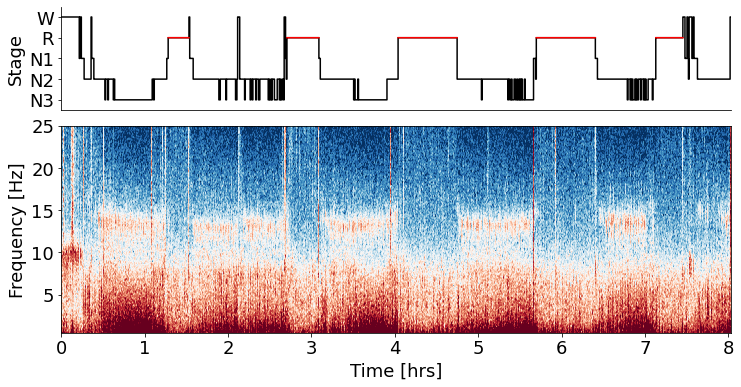

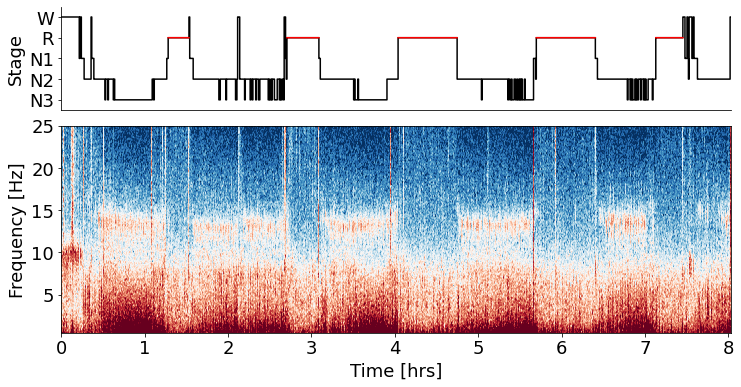

In [14]:
# we select only the C$-A1 EEG channel
yasa.plot_spectrogram(data[chan.index("C4-A1")], sf, hypno_up)

29-Mar-22 08:36:11 | INFO | Using pre-trained classifier: C:\Users\CYS\anaconda3\lib\site-packages\yasa\classifiers\clf_eeg_lgb_0.5.0.joblib


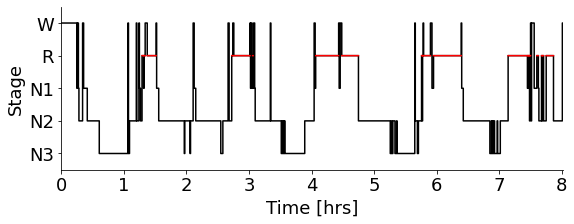

In [15]:
# automatic sleep staging
sls = yasa.SleepStaging(raw, eeg_name='C3-A2')
hypno_pred = sls.predict()  # Predict the sleep stages
hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred);  # Plot

In [16]:
from sklearn.metrics import accuracy_score
print(f"The accuracy is {100 * accuracy_score(hypno, hypno_pred):.3f}%")b

The accuracy is 82.676%
